In [1]:
import numpy as np
import os
import scipy

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import rc
from matplotlib import animation
from matplotlib.colors import ListedColormap

matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
# plt.style.use('dark_background')
rc('animation', html = 'jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**128

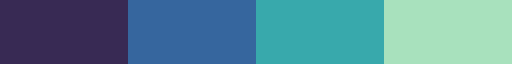

In [34]:
cmap = sns.color_palette('mako', as_cmap=True)
col = cmap(np.linspace(0.2, 0.9, 4))
cmap = ListedColormap(col)
cmap

#### Constantes

In [24]:
hbar = scipy.constants.hbar
m_e = scipy.constants.m_e
e_charge = scipy.constants.e
epsilon0 = scipy.constants.epsilon_0

D = e_charge**2 / (4 * np.pi * epsilon0)
A_to_m = 1e-10
C = 2.0 * m_e / (hbar**2)

In [19]:
J_to_eV = 1.0 / e_charge

def eV_to_J(eV):
    return eV * e_charge

#### Parámetros iniciales

In [ ]:
x_min = 0.01  # [m] (valor pequeño para comenzar la integración)
x_max = 5.0  # [m] (valor máximo para integrar, abarcando varios radios de Bohr)
dx = 0.001     # [m] (paso de integración lo suficientemente pequeño para garantizar una buena precisión)

# Convertimos a metros
x_min = x_min * A_to_m
x_max = x_max * A_to_m
dx    = dx    * A_to_m

C = 2.0 * m_e / (hbar**2)

#### Función y derivada de $\psi (x)$

In [ ]:
def psi_second_derivative(x, psi, E):
    """
    Calcula la segunda derivada de ψ en la posición x, usando:
       ψ''(x) = (2m/ħ²) * [U(x) - E] * ψ(x)
    Donde el potencial U(x) es:
       U(x) = - D / x
    Parámetros:
      x   : posición en m (float)
      psi : valor de la función en x (float)
      E   : energía (en J) (float)
    Retorna:
      Valor de ψ''(x) (float)
    """
    return -C * (E + D/x) * psi

#### Integración

In [22]:
def integrate_wavefunction(E_joule):
    """
    Integra la ecuación de Schrödinger desde x_min hasta x_max
    para una energía E usando:
        ψ(x+dx) = ψ(x) + ψ'(x)*dx + 0.5 * ψ''(x) * dx²
        ψ'(x+dx) = ψ'(x) + ψ''(x)*dx

    Parámetros:
      E : energía (en J) (float)
    Retorna:
      x_arr   : posiciones (numpy array)
      psi_arr : valores de la función de ψ(x) (numpy array)
      dpsi_arr: valores de la derivada dψ/dx (numpy array)
    """

    x_arr = np.arange(x_min, x_max, dx)
    psi_arr = np.zeros_like(x_arr)
    dpsi_arr = np.zeros_like(x_arr)

    # Condiciones iniciales:
    psi_arr[0]  = x_arr[0]
    dpsi_arr[0] = 1.0

    for i in range(len(x_arr)-1):
        x     = x_arr[i]
        psi   = psi_arr[i]
        dpsi  = dpsi_arr[i]

        # k1 para la derivada
        ddpsi = psi_second_derivative(x, psi, E_joule)

        # Euler 1/2 paso para obtener valor intermedio
        psi_mid  = psi  + 0.5*dx*dpsi
        dpsi_mid = dpsi + 0.5*dx*ddpsi
        x_mid    = x + 0.5*dx
        # k2 con valores intermedios
        ddpsi_mid = psi_second_derivative(x_mid, psi_mid, E_joule)

        psi_arr[i+1]  = psi  + dpsi_mid*dx
        dpsi_arr[i+1] = dpsi + ddpsi_mid*dx

    return x_arr, psi_arr, dpsi_arr

#### Encontrar la energía que hace ψ(x_max) ~ 0

In [11]:
def shoot_energy(E_lower_eV, E_upper_eV, tol=1e-7, max_iter=100):
    """
    Realiza el método de bisección en el intervalo [E_lower_eV, E_upper_eV]
    (en eV) para buscar la energía E que cumpla ψ(x_max)=0 (aprox).
    Devuelve la energía en eV.
    """
    E_low_J  = eV_to_J(E_lower_eV)
    E_high_J = eV_to_J(E_upper_eV)

    for _ in range(max_iter):
        E_mid_J = 0.5*(E_low_J + E_high_J)

        x_arr, psi_arr, _ = integrate_wavefunction(E_mid_J)
        psi_end_mid = psi_arr[-1]

        _, psi_low, _ = integrate_wavefunction(E_low_J)
        psi_end_low = psi_low[-1]

        if np.sign(psi_end_mid) == np.sign(psi_end_low):
            E_low_J = E_mid_J
        else:
            E_high_J = E_mid_J

        if abs(psi_end_mid) < tol:
            break

    return 0.5*(E_low_J + E_high_J) * J_to_eV

#### Intervalos de energía para cada estado

In [16]:
states_brackets = {
    1: (-14, -13),   # Estado fundamental (n=1)
    2: (-3.5, -3.3),  # Primer estado excitado (n=2)
    3: (-1.6, -1.4),  # Segundo estado excitado (n=3)
    4: (-0.9, -0.8),  # Tercer estado excitado (n=4)
}

#### Búsqueda de Valores Propios y Resultados

In [14]:
energies_eV = {}
wavefunctions = {}

In [25]:
for n, (E_low, E_high) in states_brackets.items():
    E_found = shoot_energy(E_low, E_high, tol=1e-9)
    energies_eV[n] = E_found

    E_found_J = eV_to_J(E_found)
    x_arr, psi_arr, _ = integrate_wavefunction(E_found_J)

    # Normalizamos la función de onda para graficarla con forma clara
    # Se usa trapz para integrar numéricamente
    norm_factor = np.sqrt(np.trapz(np.abs(psi_arr)**2, x_arr))
    if norm_factor != 0:
        psi_arr /= norm_factor
    wavefunctions[n] = (x_arr, psi_arr)

#### Gráfica

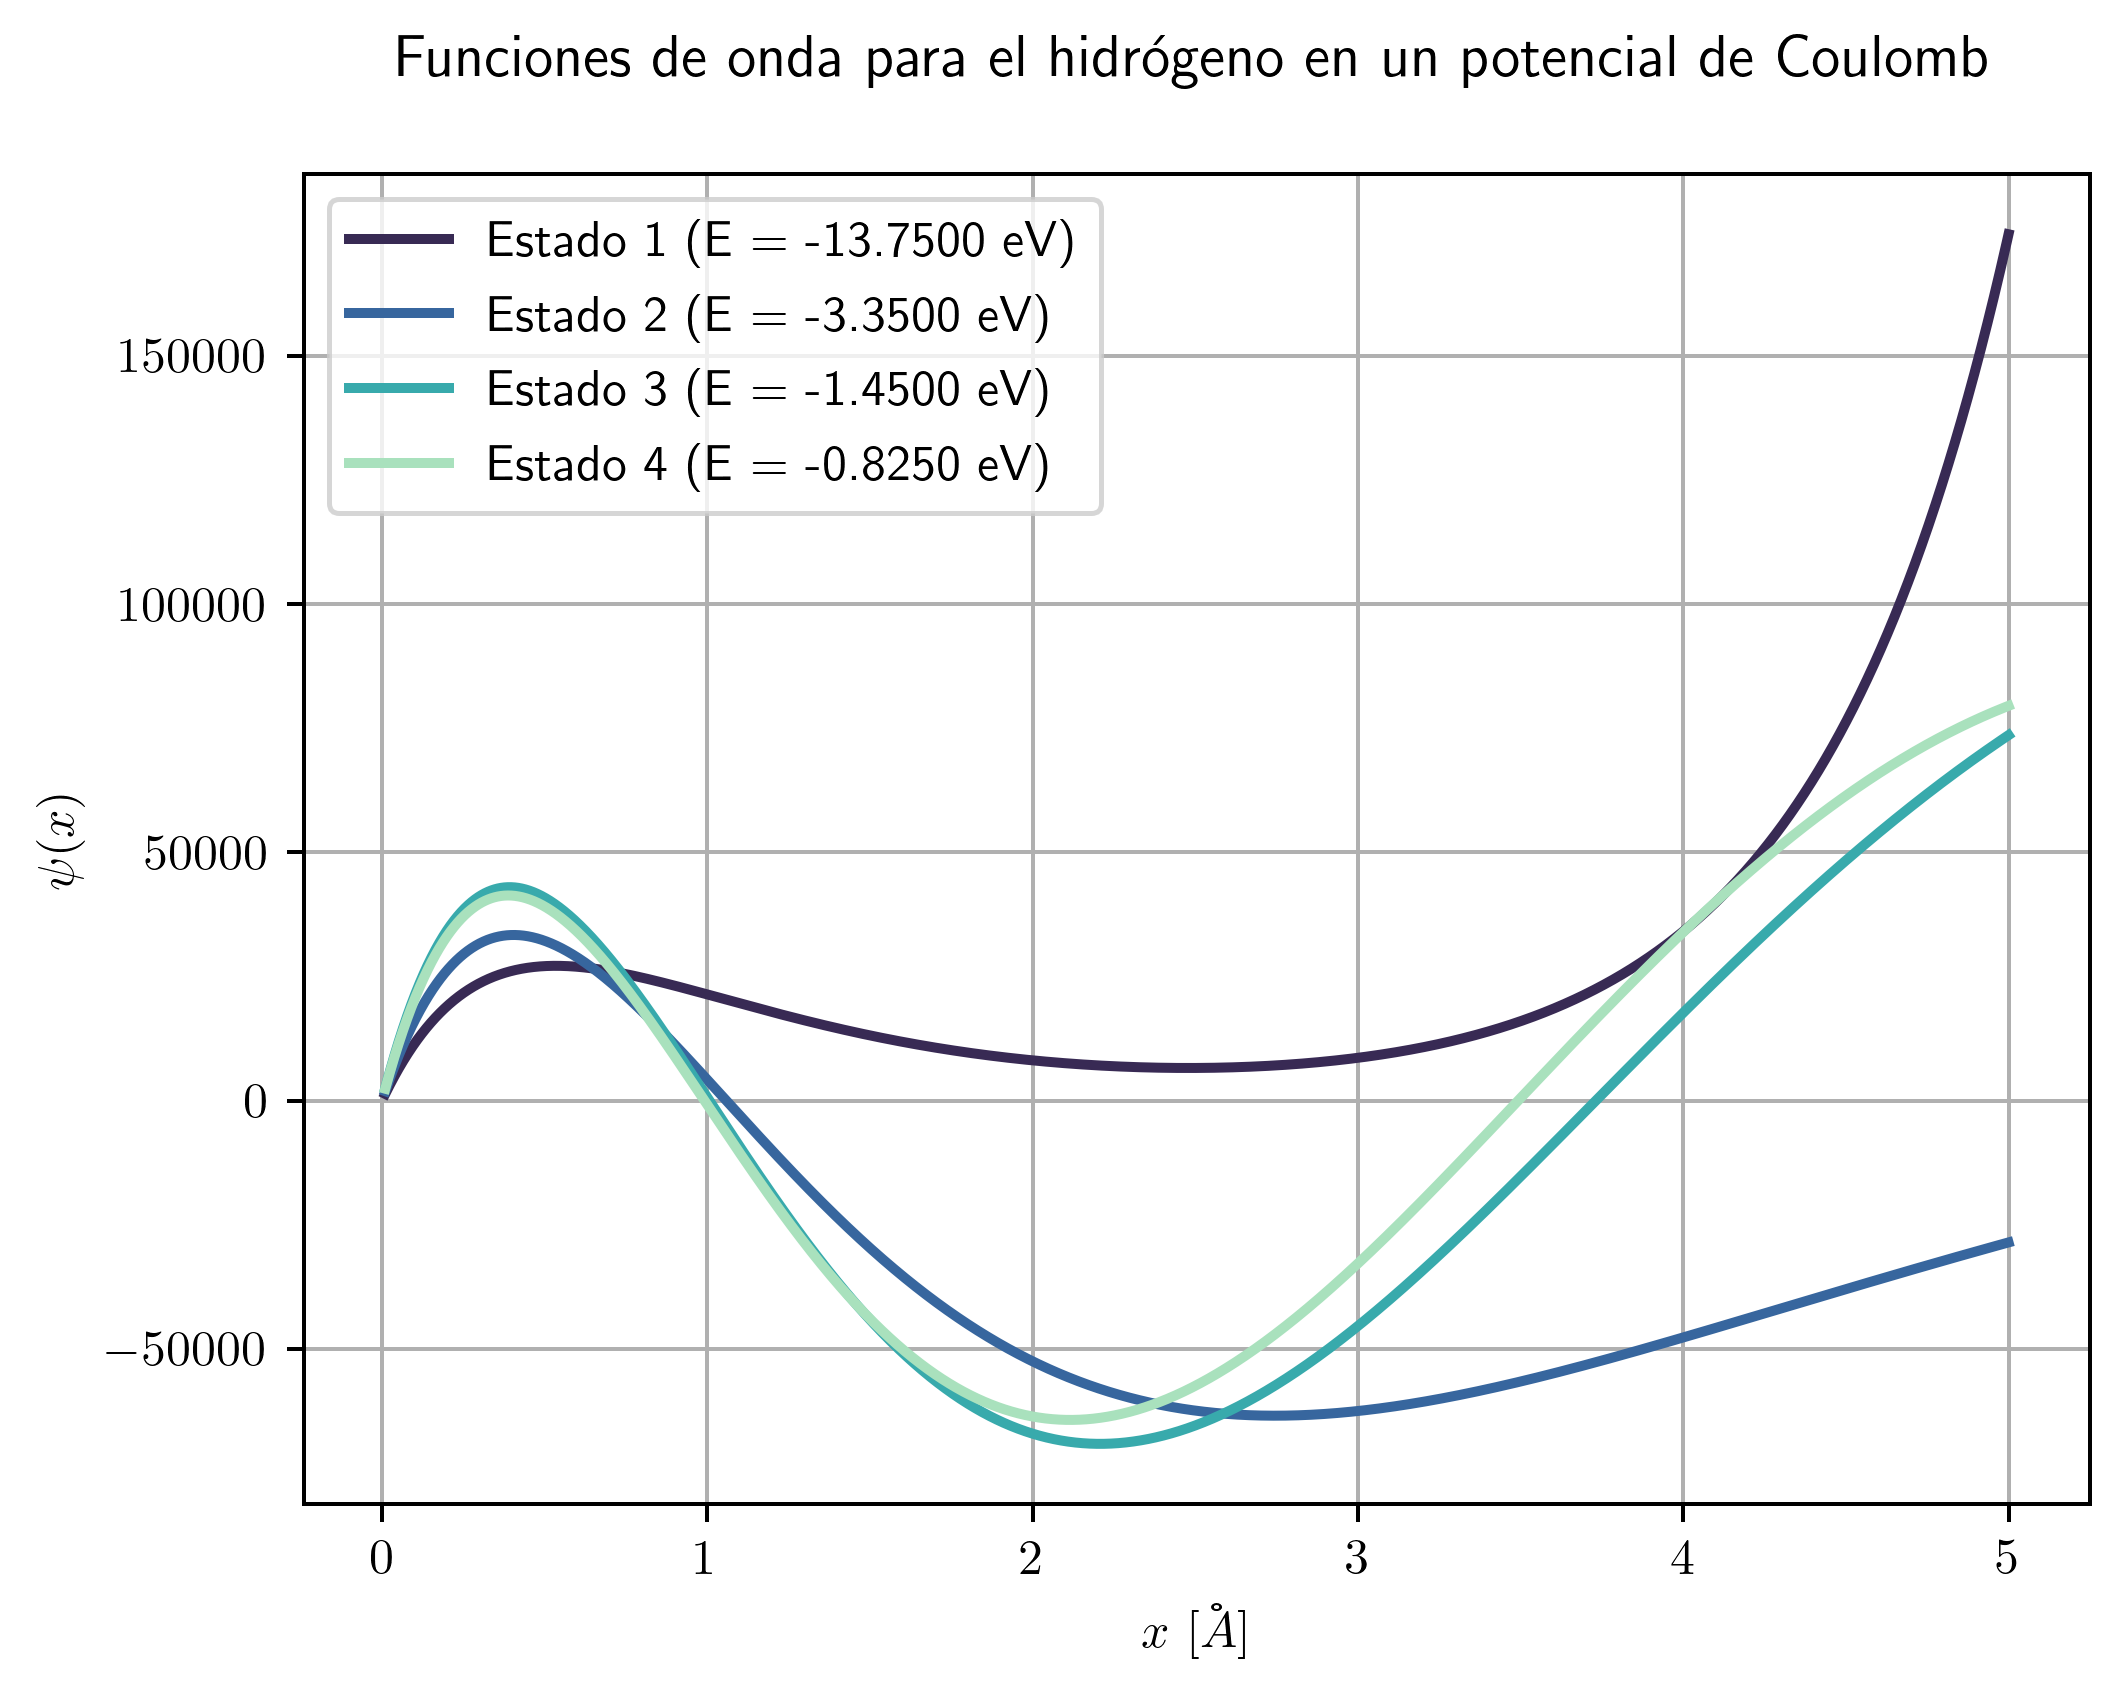

In [35]:
figure = plt.figure()
ax = figure.add_subplot(111)

for i, n in enumerate(sorted(wavefunctions.keys())):
    xvals, psivals = wavefunctions[n]
    xvals_A = xvals / A_to_m
    Eev     = energies_eV[n]
    label_txt = f"Estado {n} (E = {Eev:.4f} eV)"
    ax.plot(xvals_A, psivals, label=label_txt, c=cmap(i), lw=2)

plt.xlabel(r"$x$ $[\r{A}]$")
plt.ylabel(r"$\psi(x)$")
plt.title("Funciones de onda para el hidrógeno en un potencial de Coulomb", y=1.05)
plt.legend()
plt.grid(True)
plt.show()